# Testing scib metrics on immune seacells integration with scvi implementation of scib

In [1]:
import scanpy as sc
import pandas as pd
import scvi
from scib_metrics.benchmark import Benchmarker

Global seed set to 0


In [2]:
initDir = '/group/testa/Project/OvarianAtlas/atlas_project/raw_data/integration/metacells/immune/'

In [7]:
adata_list={'seacells_hdg_patients_batch_corr_scgen_celltypes_embeddings_2500.h5ad':'scGen_HVG',
            'seacells_hdg_patients_batch_corr_scgen_celltypes_embeddings_HDG.h5ad':'scGen_HDG',
            'seacells_hdg_patients_batch_corr_scVI_celltypes_embeddings_2500.h5ad':'scVI_HVG',
            'seacells_hdg_patients_batch_corr_scANVI_celltypes_embeddings_2500.h5ad':'scANVI_HVG',
            'seacells_hdg_patients_batch_corr_scVI_celltypes_embeddings_HDG.h5ad':'scVI_HDG',
            'seacells_hdg_patients_batch_corr_scANVI_celltypes_embeddings_HDG.h5ad':'scANVI_HDG'}

In [8]:
# Load the first AnnData object to store all embeddings
first_file = list(adata_list.keys())[0]
adata_first = sc.read(initDir + first_file)

In [5]:
# Function to get the correct embedding key based on the filename
def get_embedding_key(filename):
    if 'scgen' in filename.lower():
        return 'corrected_latent'
    elif 'scvi' in filename.lower():
        return 'X_scVI'
    elif 'scanvi' in filename.lower():
        return 'X_scANVI'
    else:
        raise ValueError(f"Unknown embedding type for file: {filename}")

In [10]:
# Iterate over each file, load the AnnData object, and extract the embeddings
for file, label in adata_list.items():
    adata = sc.read_h5ad(initDir + file)
    embedding_key = get_embedding_key(file)
    embeddings = adata.obsm[embedding_key]
    adata_first.obsm[label] = embeddings

In [11]:
adata_first

AnnData object with n_obs × n_vars = 15042 × 2500
    obs: 'tissue', 'developmental_stage', 'treatment', 'recurrence', 'tumor_stage', 'paper_ID', 'anatomical_location', 'dataset', 'SEACell', '# Single Cells', 'tissue-treatment', 'Plasma_cells', 'T_cells', 'Mast_cells', 'B_cells', 'Myeloid_cells', 'Dendritic_cells', 'cell_types', '_scvi_batch', '_scvi_labels', 'S_score', 'G2M_score', 'phase'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_types_colors', 'dataset_colors', 'neighbors', 'paper_ID_colors', 'pca', 'phase_colors', 'tissue-treatment_colors', 'tissue_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'corrected_latent', 'latent', 'scGen_HVG', 'scGen_HDG', 'scVI_HVG', 'scANVI_HVG', 'scVI_HDG', 'scANVI_HDG'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
bm = Benchmarker(
    adata_first,
    batch_key="paper_ID",
    label_key="cell_types",
    embedding_obsm_keys=['scGen_HVG', 'scGen_HDG', 'scVI_HVG', 'scANVI_HVG', 'scVI_HDG', 'scANVI_HDG'],
    n_jobs=-1,
)
bm.benchmark()

Embeddings:   0%|          | 0/6 [00:00<?, ?it/s]WARNING:jax._src.lib.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/marta.sallese/ov_cancer_atlas/miniconda3/envs/scvi/lib/python3.9/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings:  33%|███▎      | 2/6 [02:26<04:48, 72.18s/it]/home/marta.sallese/ov_cancer_atlas/miniconda3/envs/scvi/lib/python3.9/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings:  50%|█████     | 3/6 [02:57<02:39, 53.31s/it]/home/marta.sallese/ov_cancer_atlas/miniconda3/envs/scvi/lib/python3.9/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contributio

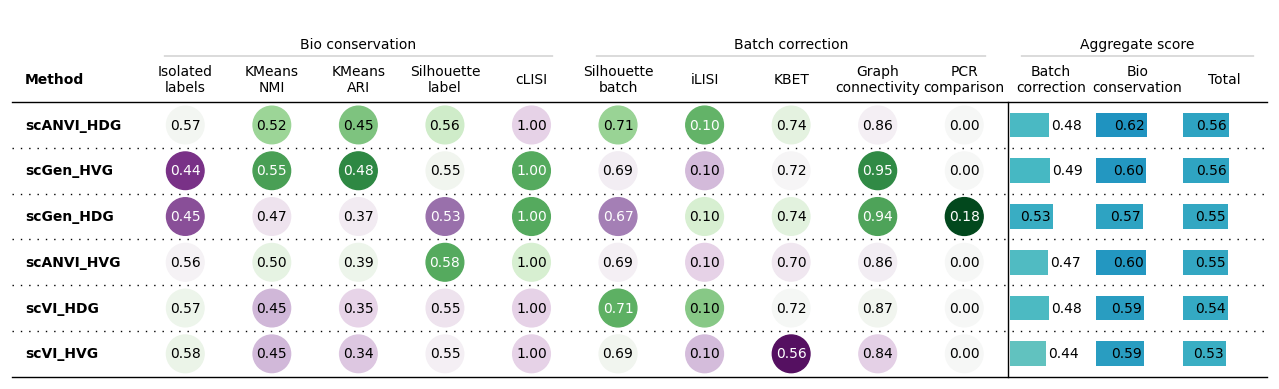

In [13]:
bm.plot_results_table(min_max_scale=False)

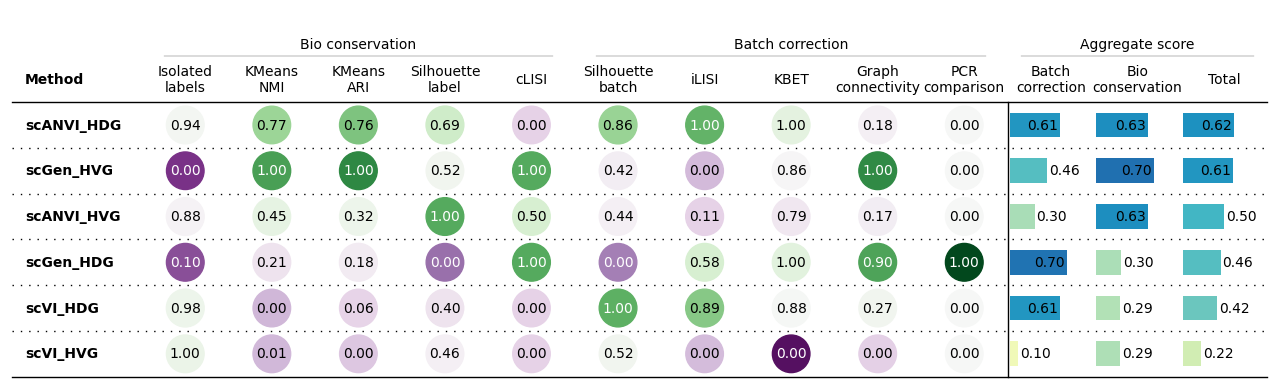

In [14]:
bm.plot_results_table(min_max_scale=True)

In [15]:
df = bm.get_results(min_max_scale=False)
print(df)

              Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                           
scGen_HVG            0.437273          0.546766          0.480229   
scGen_HDG            0.451825          0.472858          0.369357   
scVI_HVG             0.576178          0.453855          0.344192   
scANVI_HVG           0.559056          0.495202          0.388318   
scVI_HDG             0.573697          0.452975          0.351932   
scANVI_HDG           0.567951          0.524855          0.447822   
Metric Type  Bio conservation  Bio conservation  Bio conservation   

             Silhouette label             cLISI  Silhouette batch  \
Embedding                                                           
scGen_HVG            0.554863               1.0           0.69049   
scGen_HDG             0.53111               1.0          0.674528   
scVI_HVG             0.551865               1.0          0.693978   
scANVI_HVG           0.576366    

In [16]:
adata_first.write_h5ad(initDir + 'seacells_immune_batch_corr_metrics.h5ad')